# Perform Land Classification using Supervised Machine Learning in 10-ish Steps

## Goal:

<i>In this tutorial, you will work with nadir-looking imagery to run supervised machine learning models to perform land classification. From this excersize, you will:

1. gain insight into setting up a geospatial machine learning model,
1. understand differences in imagery types,
1. create testing and training data for supervised modelling,
1. evalaute performance against multiple model types,
1. gain knowledge of streaming pixels from the cloud. </i>

## Background

Land classification is the technique of labelling each individual pixel in an image with its relevant class (e.g. water, road, tree, etc). In remote sensing, there is a long history of this process, largely driven by manual labor. With the rise of increased acquisition from digital sensor platforms, at high resolution, manual classification is unscalabile and can have inherent human biases. Machine learning is ideal for land classification in its ability to scale the pixel-wise labelling exponentially. A Support Vector Machine implementation is very straightfoward, and is discusssed here. However, for large-scale processing workflows, Convolutional Neural Networks (CNN) have become ideal.

![alt-text](lc.png "Logo Title Text 1")

<i>Figure 1. RGB overhead imagery (left) is used in combination with truth data to perform a pixel-size land classification (far right), where each pixel is translated from an RGB value to a label class. In this case, the classes are pool (cyan), impervious surface (grey), tree/shrub (dark green), irrigated lawn (light green), shadows (dark grey), natural/non-irrirgated lawn (brown). This land classification map was produced using a deep learning Convolutional Neural Network.</i>

### 1. <b><u>To start</u></b>, get the necessary libraries:


In [3]:
# Get all the libraries

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os
import cv2


### 2. Define some functions. 

We will define some functions that can read an image from cloud storage on Amazon S3 and stream it into memory and also a few plotting function for later.

In [4]:
def stream2npy(img_stream):
    '''convert image in-memory stream to an numpy array'''
    arr = np.asarray(bytearray(img_stream['Body'].read()), dtype=np.uint8)
    return arr

def statsdata(arr):
    '''generate histogram of training data'''
    fig=plt.figure(figsize=(7, 7))
    bins = range(8)
    plt.hist(arr, bins=bins)  # arguments are passed to np.histogram
    bins_labels(bins, fontsize=20)
    plt.title('Distribution of Training Data Classes')
    plt.xlabel('Classes')

def bins_labels(bins, **kwargs):
    '''center the histogram bin labels due to OCD'''
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])



### 3. Grab data from the cloud.

We will grab two sets of data from an S3 bucket in the form of a geotif. You can also download these locally to play with later (```s3.Bucket(BUCKET_NAME).download_file(KEY_DG, '/my_local_path/'+KEY_DG)```). For now, we will just stream the pixel data into memory for processing. Evaluate the print statements. 

<span style="color:fuchsia"><b>Question:</b></span> What type of information do you see?

In [5]:
# Download the imagery from AWS S3 to local memory

BUCKET_NAME = 'uw-geohack' # replace with your bucket name
KEY_DG = 'la_digitalglobe_small.tif' 
KEY_EV = 'la_eagleview_small.tif' 

s3 = boto3.resource('s3')
s3_client = boto3.client('s3',config=Config(signature_version=UNSIGNED))

img_stream_dg = s3_client.get_object(Bucket=BUCKET_NAME, Key=KEY_DG)
img_stream_ev = s3_client.get_object(Bucket=BUCKET_NAME, Key=KEY_EV)

print('DG:', img_stream_dg)
print('EV: ',img_stream_ev)


DG: {'ResponseMetadata': {'RequestId': '92135B8571F20072', 'HostId': 'THNVWfaUWTewm+5oqxNdWvhJ94ilU9GpCLNho47Rsx9LLqku9Bsx1UHiBp3znMvBLqqmCEfYmhI=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'THNVWfaUWTewm+5oqxNdWvhJ94ilU9GpCLNho47Rsx9LLqku9Bsx1UHiBp3znMvBLqqmCEfYmhI=', 'x-amz-request-id': '92135B8571F20072', 'date': 'Wed, 12 Sep 2018 16:39:01 GMT', 'last-modified': 'Sun, 02 Sep 2018 04:08:40 GMT', 'etag': '"4ef20604a93f2c5a5678459acafd24d9"', 'accept-ranges': 'bytes', 'content-type': 'image/tiff', 'content-length': '192673', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'AcceptRanges': 'bytes', 'LastModified': datetime.datetime(2018, 9, 2, 4, 8, 40, tzinfo=tzutc()), 'ContentLength': 192673, 'ETag': '"4ef20604a93f2c5a5678459acafd24d9"', 'ContentType': 'image/tiff', 'Metadata': {}, 'Body': <botocore.response.StreamingBody object at 0x00000279FDB81080>}
EV:  {'ResponseMetadata': {'RequestId': '6878B41D5ED8A57B', 'HostId': 'i31CKEOHBPfEdqGiYNBoHuDyYX7IXPqgwYVt695VReu2QGW3HI6iSQWD

In [6]:
# Read the data into memory and convert it to a numpy array or pixels in RGB space
img1=stream2npy(img_stream_dg)
img1_de = cv2.imdecode(img1, -1)
img1_rgb = cv2.cvtColor(img1_de, cv2.COLOR_BGR2RGB)   #Why do we need to do this? What is this doing?

img2=stream2npy(img_stream_ev)
img2_de = cv2.imdecode(img2, -1)
img2_rgb = cv2.cvtColor(img2_de, cv2.COLOR_BGR2RGB)


### 4. Let's visualize the results. 


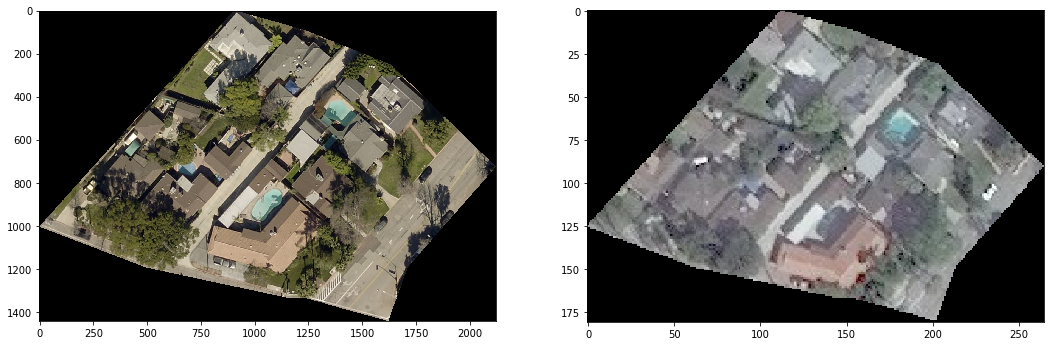

In [7]:
fig=plt.figure(figsize=(18, 16))
plt.subplot(1, 2, 1)
plt.imshow(img2_rgb)
plt.subplot(1, 2, 2)
plt.imshow(img1_rgb)


<span style="color:fuchsia"><b>Question:</b></span> One image is satellite imagery and one is aerial imagery. Can you tell which is which? Why? What other observations can you make about these images?

left is taken from an airplane and it's like 3 inch resolution, where the one on the right comes from a satellite with like .5m resolution


### 5. Get the training data too

We downloaded the RGB imagery for the aerial and satellite images. Now we need to get the two corresponding training data sets. 

<span style="color:fuchsia"><b>Question:</b></span> Why are there two different data sets? 

the image sets themselves are super different and sometimes pixels don't exactly line up, so two training sets are created at the two different resolutions to try to capture as much as possible

In [9]:
TRAIN_EV = 'training_data_ev.tif'
TRAIN_DG = 'training_data_dg.tif'


train_stream = s3_client.get_object(Bucket=BUCKET_NAME, Key=TRAIN_EV)
train=stream2npy(train_stream)
train_de = cv2.imdecode(train, -1)

train_stream2 = s3_client.get_object(Bucket=BUCKET_NAME, Key=TRAIN_DG)
train2=stream2npy(train_stream2)
train2_de = cv2.imdecode(train2, -1)

print('Shape of the Training data:', train_de.shape)
print('Shape of the Image data:', img2_rgb.shape)

print('Shape of the Training data:', train2_de.shape)
print('Shape of the Image data:', img1_rgb.shape)

Shape of the Training data: (1444, 2122)
Shape of the Image data: (1444, 2122, 3)
Shape of the Training data: (181, 265)
Shape of the Image data: (181, 265, 3)


<span style="color:fuchsia"><b>Question:</b></span> What do you notice about the training and image data shapes? Do they make sense?  

the training data itself is 2 dimensions while the actual imagery is 3 dimensions, training data is made up of a boolean class of what it is (classes ranging from 0-6 corresponding to water, land, etc...)

### 6. So we cheated... (how to make more training data if you need) 

I hooked you up with the training data. But (as you may discover soon) you will want to add, modify, or change the training data. 

<b><u>Creating more training data:</u></b> The training data was created in QGIS as a geojson vector layer on a local machine. This layer was rasterized using the command line [rasterio tools](https://github.com/mapbox/rasterio) like so:

```rio rasterize training_data.tif --like la_eagleview_small.tif --property id --fill 0 < training_data.geojson```

To use these tools, clone the rasterio repo and use on the local command line.

The string `id` is the attribute name of the class you labeled with a polygon and `--fill` will fill all no-data areas with the `0` value.

<b><u>Saving local copies of the images:</b></u> The training data geojson and the image have to both be in the same CRS, of course. And you'll want to save the streaming (in-memory) images to your local machine:

```s3.Bucket(BUCKET_NAME).download_file(KEY_DG, '/my_local_path/'+KEY_DG)```


### 7. Let's evaluate the training data for the satellite image.

The training data array has values corresponding to this key of classes. Here is your key:

`0 - unclassified, 1 - pool, 2 - street, 3 - grass, 4 - roof, 5 - tree, 6 - shadow`

But let's double check on the contents of the training data. For now, we are just going to look at one set of training data due to time constraints. But the same technique we use here can be applied to the other dataset. Let's use the smaller dataset, `train_de`.

In [12]:
classes = {'pool': 1, 'street': 2, 'grass': 3, 'roof': 4, 'tree': 5, 'shadow': 6}
n_classes = len(classes)
print('Unique values in training array: ',np.unique(train_de))

# create a color palette we will use to colorize the predictions later
palette = np.uint8([[0, 0, 0],[0, 255, 255], [128, 128, 128], [0, 255, 0],[255, 255, 255],[0, 102, 0],[51, 51, 51]])



Unique values in training array:  [0 1 2 3 4 5 6]


<span style="color:fuchsia"><b>Question:</b></span> What about the distribution of class types? Let's visualize that as well in order to understand more about our data set...

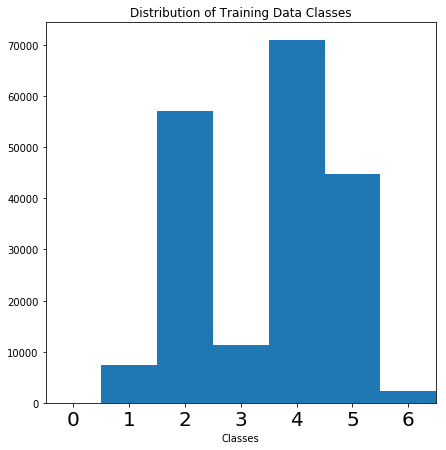

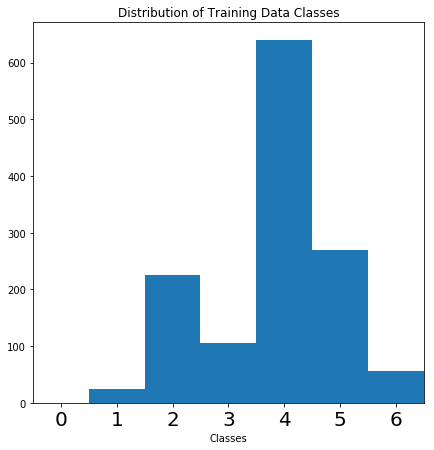

In [13]:
statsdata(train_de[train_de>0].ravel())
statsdata(train2_de[train2_de>0].ravel())



<span style="color:fuchsia"><b>Question:</b></span> What could the distribution of the training data indicate? 
What changes could be useful?

### 8. Let's create a training data mask.

We will need to mask out the parts of the RGB image we wont be using. If we don't that will create confusion.

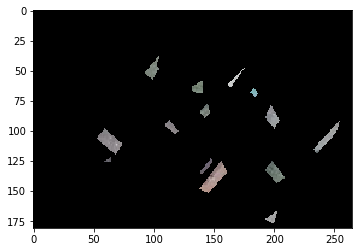

In [14]:
rows, cols, bands = img1_rgb.shape
full=img1_rgb[:,:,0:3]        #Why do we do this?
full=full.ravel()
full=full.reshape((-1, 1))    #Set this guy aside for full prediction

red=img1_rgb[:,:,0]
green=img1_rgb[:,:,1] 
blue=img1_rgb[:,:,2]

# remove all the 'class 0' from the training data
red=np.where(train2_de>0, red,0)
green=np.where(train2_de>0, green,0)
blue=np.where(train2_de>0, blue,0)

# create a mask with the same dimensions
Xtrain=np.dstack((red,green,blue))
Ylabel=np.dstack((train2_de,train2_de,train2_de))

# flatten
data = Xtrain.ravel()     
label= Ylabel.ravel()  

# remove all the 'class 0' from the training data
l=label[label>0]
d=data[label>0]
d=d.reshape((-1, 1)) 


plt.imshow(Xtrain)

<span style="color:fuchsia"><b>Question: </b></span>What do you notice about this image above?

### 9. Training the SVM

What is a Support Vector Machine (SVM)? Given a set of labeled training data (supervised learning), the SVM outputs an optimal hyperplane which categorizes new data (not used in training). For a simple case of two classes in 2 dimensional space, the hyperplane is a line dividing a plane in two parts where each of the 2 classes lay on either side. SVMs are useful for classification problems where you would like to different among mulitple classes. However, as we will see, it can fall short due to scalability and processing overhead.

C:\Users\Miya\Miniconda3\Lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


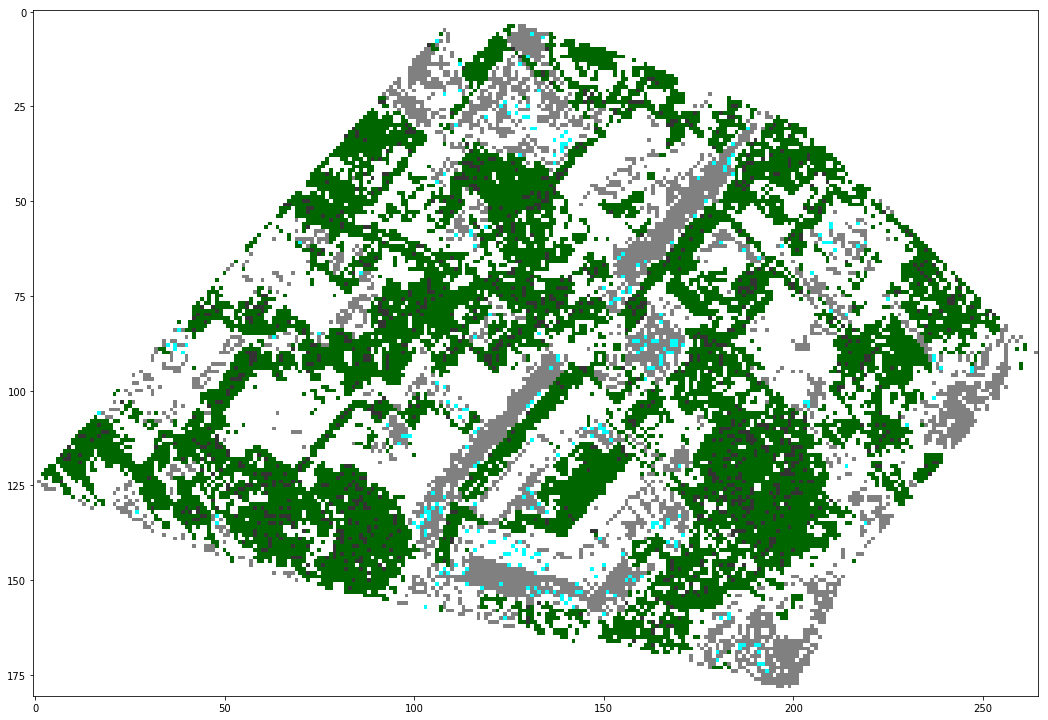

In [15]:
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split #

# split the training data up so we can test later
#this splits the training data up so you can validate the data later
X_train, X_test, y_train, y_test = train_test_split(d, l, test_size=0.25)

clf = SVC() #svm class
clf.fit(X_train, y_train)
y_t = clf.predict(full)
predicted=y_t.reshape(rows, cols,3)

fig=plt.figure(figsize=(18, 16))
plt.imshow(palette[predicted][:,:,0]) #this palette was defined earlier based on making trees green, roads grey, etc.


<span style="color:fuchsia"><b>Question: </b></span>What do you notice about the results? How could we improve them?

### 10. What is the model's performance?

Let's create a confusion matrix with the test data we held back.

In [16]:
from sklearn import datasets, svm, metrics
expected = y_test
predicted = clf.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          1       1.00      0.07      0.12        15
          2       0.69      0.75      0.72       163
          3       0.00      0.00      0.00        83
          4       0.69      0.84      0.75       459
          5       0.60      0.63      0.62       222
          6       0.41      0.15      0.22        48

avg / total       0.60      0.66      0.62       990


Confusion matrix:
[[  1   0   0  13   1   0]
 [  0 123   0  34   6   0]
 [  0   0   0  57  26   0]
 [  0  55   0 385  18   1]
 [  0   0   0  73 140   9]
 [  0   0   0   0  41   7]]


C:\Users\Miya\Miniconda3\Lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<span style="color:fuchsia"><b>Question: </b></span> How can we define accuracy? Precision? What is recall?


### 11. Train another type of ML model

Let's try out a random forest classifier. What is a random forest (RF) classifier? An RF classifier constructs  decision trees during supervised training and outputs the class that is the mode of the classification of the individual trees.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


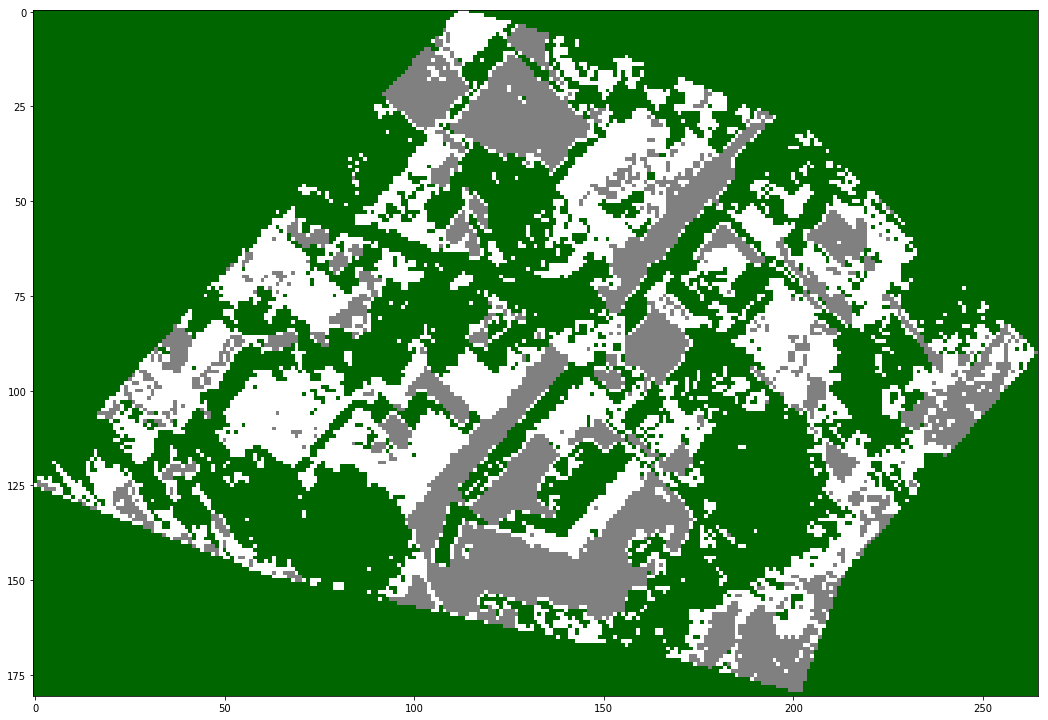

In [25]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_rf = clf.predict(full)
predictedRF=y_rf.reshape(rows, cols,3)

fig=plt.figure(figsize=(18, 16))
plt.imshow(palette[predictedRF][:,:,0])



### 13. What about the other image?

What happens when we apply the learned model to the aerial imagery with the higher resolution? Try is out using the above recipe. It may take a while given the amount of pixels in the aerial image.

<span style="color:fuchsia"><b>Question: </b></span>What kind of differences do you expect? 
